In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
     --------------------------------------- 0.0/12.0 MB 262.6 kB/s eta 0:00:46
     --------------------------------------- 0.0/12.0 MB 281.8 kB/s eta 0:00:43
     --------------------------------------- 0.1/12.0 MB 722.1 kB/s eta 0:00:17
      -------------------------------------- 0.2/12.0 MB 958.4 kB/s eta 0:00:13
      -------------------------------------- 0.2/12.0 MB 958.4 kB/s eta 0:00:13
     - -------------------------------------- 0.5/12.0 MB 1.7 MB/s eta 0:00:07
     -- ------------------------------------- 0.6/12.0 MB 1.8 MB/s eta 0:00:07
     --- ------------------------------------ 1.0/12.0 MB 2.7 MB/s eta 0:00:05
     ---- ----------------------------------- 1.5/12.0 MB 3.3 MB/s eta 0:00:04
     ------ --------------------------------- 2.1/12.0 MB 4.2 MB/s eta 0:00:03
     ------ --------------------------------- 2.1/12.0 MB 4.2

C:\Users\Admin\anaconda3\lib\site-packages\spacy\util.py:918: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.5,<3.8.0
  warnings.warn(warn_msg)


In [25]:
data = pd.read_csv("Metadata1.csv")

In [12]:
data_p = data[data["label"]=="Flooding"]
data_n = data[data["label"]=="No Flooding"]

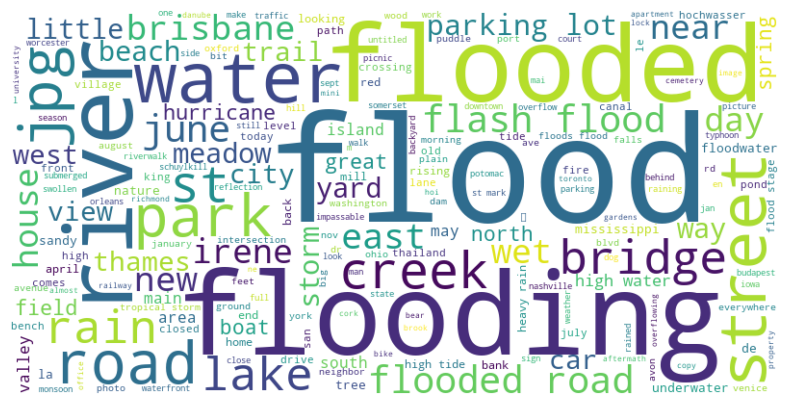

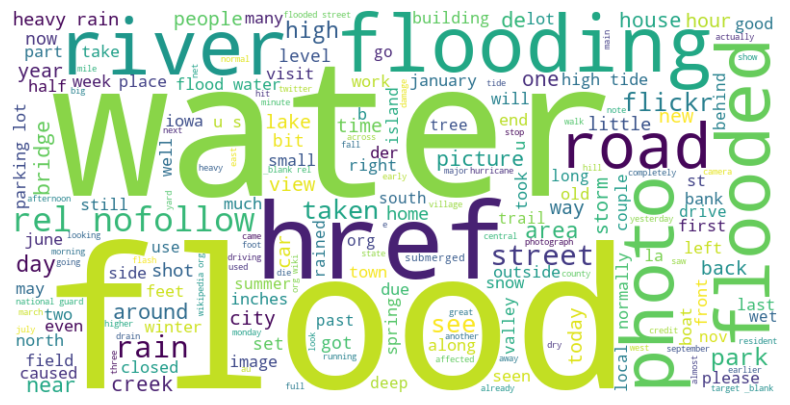

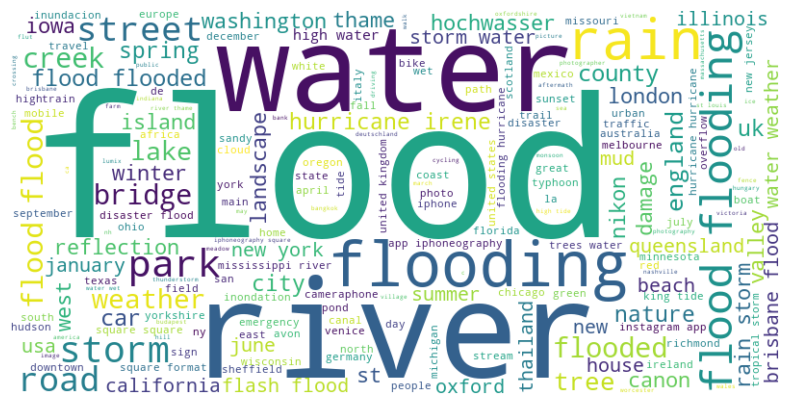

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

generate_wordcloud(data_p['title'].dropna())
generate_wordcloud(data_p['description'].dropna())
generate_wordcloud(data_p['user_tag_to_str'].dropna())

In [36]:
data = data.fillna('')
data['text'] = data.apply(lambda row: ' '.join([row['description'],row['title'],row['user_tag_to_str']]), axis=1) 
data = data[['image_id','text','label']]
data

,image_id,text,label
0,3519864665,biltmore estate 2009 road trip obrero road trip,No Flooding
1,4896119055,chand minar daulatabad daulatabad fort ellora...,No Flooding
2,3468473862,"after the flood, the boarded up stores bear up...",No Flooding
3,4120853942,dscf6487 cork enchente flood ireland irlanda,No Flooding
4,4436083254,oconoe river - flooded athens georgia brown c...,No Flooding
...,...,...,...
5275,8119782888,90 550d camino canon canoneos550d canoneoskis...,No Flooding
5276,6093294301,"albany's corning preserve, day after irene al...",Flooding
5277,6791185487,img_4989 al the waters in pike road,No Flooding
5278,9144682941,2013 fair flood img_3011 2013 county fair floo...,No Flooding


In [34]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
data['Cleaned_text'] = data['text'].apply(lambda x: remove_URL(x))
data['Cl_text']= data['text'].apply(lambda x: remove_html(x))
data['text']= data['description'].apply(lambda x: remove_punct(x))

TypeError: expected string or bytes-like object

In [18]:
data['text'] = data.apply(lambda row: ' '.join([row['description'],row['title'],row['user_tag_to_str']]), axis=1) 
data1 = data[['image_id','text','label']]
data1

,image_id,text,label
0,3519864665,biltmore estate 2009 road trip obrero road trip,No Flooding
1,4896119055,chand minar daulatabad daulatabad fort ellora...,No Flooding
2,3468473862,"after the flood, the boarded up stores bear up...",No Flooding
3,4120853942,dscf6487 cork enchente flood ireland irlanda,No Flooding
4,4436083254,oconoe river - flooded athens georgia brown c...,No Flooding
...,...,...,...
5275,8119782888,90 550d camino canon canoneos550d canoneoskis...,No Flooding
5276,6093294301,"albany's corning preserve, day after irene al...",Flooding
5277,6791185487,img_4989 al the waters in pike road,No Flooding
5278,9144682941,2013 fair flood img_3011 2013 county fair floo...,No Flooding


In [7]:
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)
data1['cleaned_text'] = data1['text'].apply(preprocess_text)   


C:\Users\Admin\AppData\Local\Temp\ipykernel_25044\987996394.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['cleaned_text'] = data1['text'].apply(preprocess_text)


In [9]:
data2 = data1[['image_id','cleaned_text','label']]
label_mapping = {'No Flooding': 0, 'Flooding': 1}
data2['label'] = data2['label'].map(label_mapping)
data2

C:\Users\Admin\AppData\Local\Temp\ipykernel_37384\627330770.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['label'] = data2['label'].map(label_mapping)


,image_id,cleaned_text,label
0,3519864665,,0
1,4896119055,chand minar,0
2,3468473862,flood boarded store bear uplifting graffiti ce...,0
3,4120853942,cork enchente flood ireland irlanda,0
4,4436083254,oconoe river flooded athens georgia brown curr...,0
...,...,...,...
5275,8119782888,,0
5276,6093294301,albany corning preserve day irene,1
5277,6791185487,al water pike road,0
5278,9144682941,2013 county fair flood linn,0


In [10]:
test_data = pd.read_csv('Clean_test.csv')
test_data = test_data.fillna(' ')

test_data['text'] = test_data.apply(lambda row: ''.join([row['description'],row['title'],row['user_tags']]), axis=1)
test_data1 = test_data[['image_id','text']]
test_data1['cleaned_text'] = test_data1['text'].apply(preprocess_text)
test_data2 = test_data1[['image_id','cleaned_text']]
test_data2

C:\Users\Admin\AppData\Local\Temp\ipykernel_37384\2227814205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['cleaned_text'] = test_data1['text'].apply(preprocess_text)


,image_id,cleaned_text
0,3483809003,denton creek overflow bank flood oakland stree...
1,3712805295,sembla que fou dedicat august entorn lany 13 a...
2,379845620,highest point sea level reacheable road
3,7343264988,heavy rain lagos nigeria still flooded partsla...
4,3843337492,also local black due tree branch power linesfl...
...,...,...
1315,6452132743,find like landscape cityscape setlandscapes ci...
1316,244899140,cool looking building parque central
1317,3073018258,liked reflection tree wet road oh driving fall...
1318,49525361,looking toward magnolia neighbor house badly f...


In [11]:
#data2.to_csv("Devset_final.csv", index=False)
#test_data2.to_csv("Testset_final.csv", index=False)

In [12]:
df = pd.read_csv("Devset_final.csv")


In [13]:
df = df.fillna("<UKN>")
df_p = df[df['label']== 1]
df_n = df[df['label']== 0]
df_p

,image_id,cleaned_text,label
8,8564707991,mornos lake man made lake currently supply ath...,1
9,3259293162,here message posted seven sunrise website name...,1
10,463023075,flooding milford nh new hampshire noreaster,1
19,11607742766,river thames flood higginson park marlow thame...,1
22,5770083797,fish creek flooded week rain fish creek park c...,1
...,...,...,...
5269,593529205,2007 flood house rain storm,1
5270,484322111,coliseum square lower garden district may 4th ...,1
5272,8036780496,imagine permanently reclaimed car clifford st ...,1
5273,2167658838,view leonie terry property currawilla outside ...,1


In [14]:
from collections import Counter
import re
import pandas as pd

def get_ngrams(text, n):
    words = text.split()
    ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
    return ngrams

def clean_text(text):
    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

def top_ngrams(text_series, n, top_n=10):
    ngram_freq = Counter()
    for text in text_series:
        cleaned_text = clean_text(text)
        ngrams = get_ngrams(cleaned_text, n)
        ngram_freq.update(ngrams)
    top_ngrams = ngram_freq.most_common(top_n)
    return top_ngrams

# Example usage



n = 1  # Change n to the desired n-gram size
top_ngrams_list = top_ngrams(df['cleaned_text'], n)

print(f"Top {n}-grams:")
for ngram, freq in top_ngrams_list:
    print(f"{ngram}: {freq} occurrences")



Top 1-grams:
('flood',): 2147 occurrences
('river',): 1467 occurrences
('road',): 1461 occurrences
('water',): 1047 occurrences
('building',): 1028 occurrences
('flooding',): 995 occurrences
('bridge',): 787 occurrences
('street',): 771 occurrences
('city',): 621 occurrences
('new',): 547 occurrences


In [15]:
best = pd.read_csv("submiss.csv")
best

,id,label
0,3483809003,1
1,3712805295,0
2,379845620,0
3,7343264988,1
4,3843337492,1
...,...,...
1315,6452132743,0
1316,244899140,0
1317,3073018258,1
1318,49525361,0


In [16]:
cleaned_tt = pd.read_csv("Testset_final.csv")
cleaned_tt

,image_id,cleaned_text
0,3483809003,denton creek overflow bank flood oakland stree...
1,3712805295,sembla que fou dedicat august entorn lany 13 a...
2,379845620,highest point sea level reacheable road
3,7343264988,heavy rain lagos nigeria still flooded partsla...
4,3843337492,also local black due tree branch power linesfl...
...,...,...
1315,6452132743,find like landscape cityscape setlandscapes ci...
1316,244899140,cool looking building parque central
1317,3073018258,liked reflection tree wet road oh driving fall...
1318,49525361,looking toward magnolia neighbor house badly f...


In [22]:
import pandas as pd

# Assuming cleaned_tt and best are already defined
data = {
    "image_id": cleaned_tt["image_id"],
    "cleaned_text": cleaned_tt["cleaned_text"],
    "label": best["label"]
}

assumption = pd.DataFrame(data)
assumption = assumption.fillna("<UKN>")
assumption_n = assumption[assumption['label']==0]
assumption_p = assumption[assumption['label']==1]

In [43]:
n = 2  # Change n to the desired n-gram size
top_ngrams_list = top_ngrams(assumption_p['cleaned_text'], n)
print(f"Top {n}-grams:")
for ngram, freq in top_ngrams_list:
    print(f"{ngram}: {freq} occurrences")

Top 2-grams:
('flood', 'flooding'): 23 occurrences
('hurricane', 'irene'): 13 occurrences
('flood', 'water'): 12 occurrences
('river', 'flood'): 11 occurrences
('heavy', 'rain'): 10 occurrences
('flooding', 'flood'): 9 occurrences
('national', 'guard'): 8 occurrences
('flash', 'flood'): 7 occurrences
('high', 'tide'): 7 occurrences
('river', 'river'): 7 occurrences
